In [1]:
!export HDF5_DISABLE_VERSION_CHECK=1

In [14]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta
from logging.config import dictConfig
import numpy as np
import datetime
import pathlib
import pandas as pd
import joblib

# externals
import xarray as xr

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# locals
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset

from downscaleml.main.config import (ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH, 
                                     NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
                                     CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
                                     OVERWRITE, DEM, DEM_FEATURES, STRATIFY,
                                     WET_DAY_THRESHOLD, VALID_SIZE, 
                                     start_year, end_year, CHUNKS, PROJECTION_PATH)

#from downscaleml.main.inputoutput import ()

from downscaleml.core.constants import (ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
                                        ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
                                        ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
                                        PREDICTANDS, ERA5_P_VARIABLES, ERA5_S_VARIABLES)

from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf
    
# module level logger
LOGGER = logging.getLogger(__name__)

def stacker(xarray_dataset):
    # stack along the lat and lon dimensions
    stacked = xarray_dataset.stack()
    dask_arr = stacked.to_array().data
    xarray_dataset = dask_arr.T
    LogConfig.init_log('Shape is in (spatial, time, variables):{}'.format(xarray_dataset.shape))
    return xarray_dataset

def doy_encoding(X, y=None, doy=False):

    # whether to include the day of the year as predictor variable
    if doy:
        # add doy to set of predictor variables
        LOGGER.info('Adding day of the year to predictor variables ...')
        X = X.assign(EoDataset.encode_doys(X, chunks=X.chunks))

    print(X)
    return X

if __name__ == '__main__':

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH, ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})

    LogConfig.init_log('Initializing PROJECTION predictors.')
    #TEMPORARY PATHWORK HERE - SOLVE IT FOR LATER
    Cmip6 = ERA5Dataset(PROJECTION_PATH.joinpath('ssp245/r101i1p1f1/'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Cmip6_ds = Cmip6.merge(chunks=CHUNKS)
    Cmip6_ds = Cmip6_ds.rename({'lon': 'x','lat': 'y'})

    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    DEM = None

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem_path = search_files(DEM_PATH, '^mswx_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem_path, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})
        
        dem_cmip6 = ERA5Dataset.dem_features(
            dem_path, {'y': Cmip6_ds.y, 'x': Cmip6_ds.x},
            add_coord={'time': Cmip6_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)
            dem_cmip6 = dem_cmip6.drop_vars(['slope', 'aspect']).chunk(Cmip6_ds.chunks)
            

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])
        Cmip6_ds = xr.merge([Cmip6_ds, dem_cmip6])

    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Cmip6_valid = Cmip6_ds.sel(time=VALID_PERIOD)
    Cmip6_valid_dummy = Cmip6_ds.sel(time=VALID_PERIOD)

    #Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
    Cmip6_valid = doy_encoding(Cmip6_valid, Cmip6_valid_dummy, doy=DOY)

    LogConfig.init_log('{}'.format(Era5_train))
    LogConfig.init_log('{}'.format(Cmip6_valid))


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:24: Initializing downscaling for period: 1979-01-01 - 2014-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:24: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HISTORICAL/r101i1p1f1/geopotential, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HISTORICAL/r101i1p1f1/temperature, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HIS

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 13149, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
    height   float64 8B ...
Data variables: (12/16)
    zg_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ...       ...
    va_500   (time, y, x) float32 360MB dask.array<c

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:37: <xarray.Dataset> Size: 6GB
Dimensions:  (time: 13149, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
    height   float64 8B ...
Data variables: (12/16)
    zg_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_850   (

<xarray.Dataset> Size: 14GB
Dimensions:  (time: 31410, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 251kB 2015-01-01 2015-01-02 ... 2100-12-30
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
Data variables: (12/16)
    zg_250   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_850   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ...       ...
    va_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), me

In [5]:
import xarray as xr
import numpy as np
from sklearn.cluster import DBSCAN

ds = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

# Select specific data variables by name
selected_vars = ['wflow_dem', 'Slope', 'thetaS', 'SoilThickness', 'KsatVer', 'Swood', 'Sl', 'M']  # Replace with your variable names
new_ds = ds[selected_vars]
mask = ~np.isnan(new_ds)

var = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/forcings.nc")

var_mean = var.mean(dim='time').rename({'precip': 'precip_mean', 'pet': 'PET_mean', 'temp': 'temp_mean'})
var_std = var.std(dim='time').rename({'precip': 'precip_std', 'pet': 'PET_std', 'temp': 'temp_std'})

merged_ds = xr.merge([new_ds, var_mean, var_std])
merged_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/14)
    wflow_dem      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Slope          (latitude, longitude) float32 161kB nan nan nan ... nan nan
    thetaS         (latitude, longitude) float32 161kB nan nan nan ... nan nan
    SoilThickness  (latitude, longitude) float32 161kB nan nan nan ... nan nan
    KsatVer        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Swood          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    ...             ...
    precip_mean    (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_mean       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float32 161kB nan nan nan ... nan nan

In [ ]:
# Mask NaNs and cluster only the valid data
mask = np.isnan(ds['var1'].values)
ds_masked = ds.where(~mask)

# Perform clustering on non-missing data
# (Use DBSCAN, KMeans, etc. on ds_masked)


In [6]:
from sklearn.cluster import DBSCAN

ds = merged_ds
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values

In [8]:
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(lat_lon_flat)


ValueError: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [4]:
n_clusters = 5  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

# Plot the clustered data array
plt.figure(figsize=(10, 6))
clustered_da.plot()
plt.title("KMeans Clustering of Adige")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the plot
plt.savefig('/home/sdhinakaran/my_Notebooks/clustered_map_adige.png')

plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

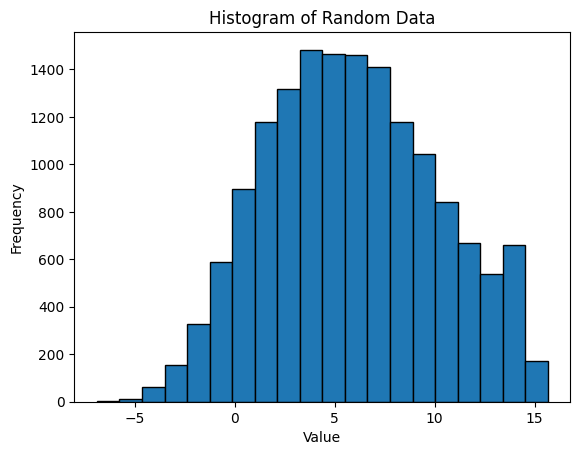

In [24]:
import matplotlib.pyplot as plt
lat_lon_flat = var_mean.to_array().stack(points=('latitude', 'longitude')).T.values

plt.hist(lat_lon_flat[:, 2], bins=20, edgecolor='black')

# Add titles and labels
plt.title("Histogram of Random Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [5]:
merged_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/14)
    wflow_dem      (latitude, longitude) float32 161kB ...
    Slope          (latitude, longitude) float32 161kB ...
    thetaS         (latitude, longitude) float32 161kB ...
    SoilThickness  (latitude, longitude) float32 161kB ...
    KsatVer        (latitude, longitude) float32 161kB ...
    Swood          (latitude, longitude) float64 321kB ...
    ...             ...
    precip_mean    (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_mean       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float32 161kB nan nan nan ... nan nan

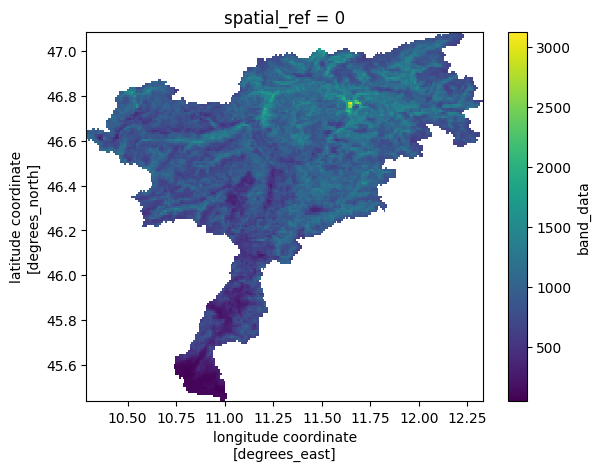

In [12]:
merged_ds.KsatVer.plot()

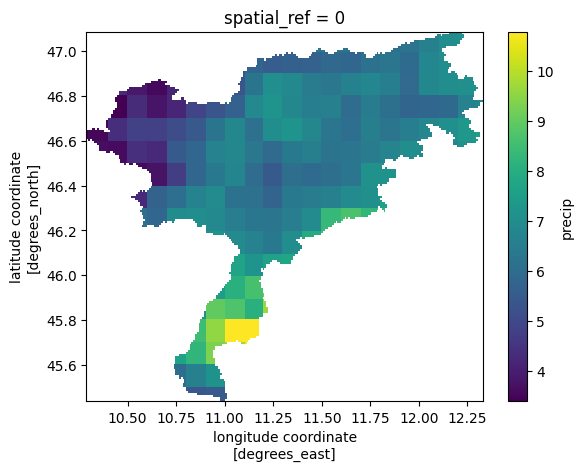

In [12]:
var_std.precip.plot()

In [6]:
from sklearn.cluster import KMeans

ds = merged_ds
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values

n_clusters = 5  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

# Plot the clustered data array
plt.figure(figsize=(10, 6))
clustered_da.plot()
plt.title("KMeans Clustering of Adige")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the plot
plt.savefig('/home/sdhinakaran/my_Notebooks/clustered_map_adige.png')

plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


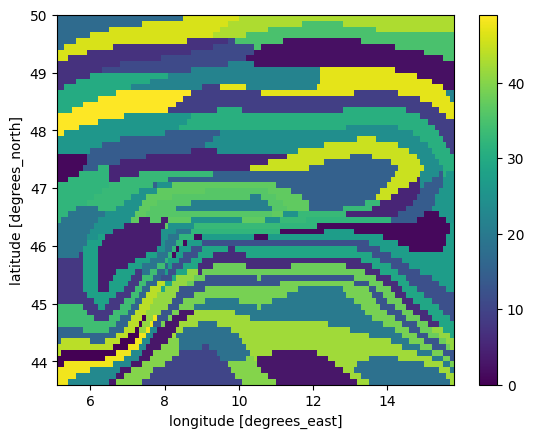

In [16]:
n_clusters = 50  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['y'], ds.sizes['x'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['y'], ds['x']], dims=['y', 'x'])

clustered_da.plot()


/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


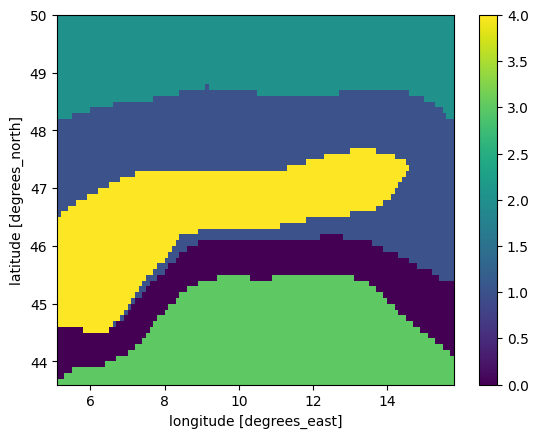

In [18]:
n_clusters = 5  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['y'], ds.sizes['x'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['y'], ds['x']], dims=['y', 'x'])

clustered_da.plot()


In [1]:
import xarray as xr
import numpy as np
from sklearn.cluster import DBSCAN

ds = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

# Select specific data variables by name
selected_vars = ['wflow_dem', 'Slope', 'thetaS', 'SoilThickness', 'KsatVer', 'Swood', 'Sl', 'M']  # Replace with your variable names
new_ds = ds[selected_vars]
#mask = ~np.isnan(new_ds)

var = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/forcings.nc")

var_mean = var.mean(dim='time').rename({'precip': 'precip_mean', 'pet': 'PET_mean', 'temp': 'temp_mean'})
var_std = var.std(dim='time').rename({'precip': 'precip_std', 'pet': 'PET_std', 'temp': 'temp_std'})

merged_ds = xr.merge([new_ds, var_mean, var_std])
merged_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/14)
    wflow_dem      (latitude, longitude) float32 161kB ...
    Slope          (latitude, longitude) float32 161kB ...
    thetaS         (latitude, longitude) float32 161kB ...
    SoilThickness  (latitude, longitude) float32 161kB ...
    KsatVer        (latitude, longitude) float32 161kB ...
    Swood          (latitude, longitude) float64 321kB ...
    ...             ...
    precip_mean    (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_mean       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float32 161kB nan nan nan ... nan nan

In [2]:
merged_ds_fill = merged_ds.fillna(9999)

In [4]:
ds = merged_ds_fill

In [5]:
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

clustered_da.plot()

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


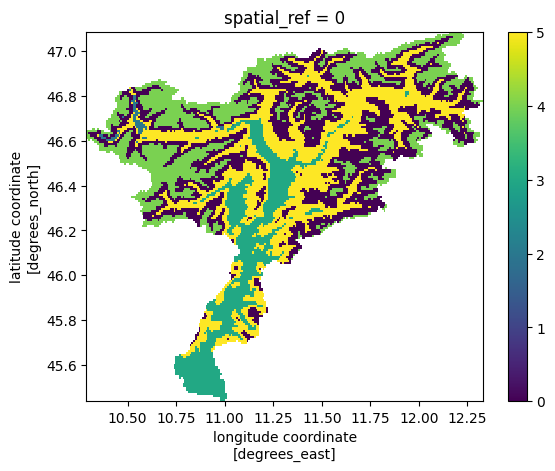

In [1]:
import xarray as xr
import numpy as np
from sklearn.cluster import KMeans

ds = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

# Select specific data variables by name
selected_vars = ['wflow_dem', 'Slope', 'thetaS', 'SoilThickness', 'KsatVer', 'Swood', 'Sl', 'M']  # Replace with your variable names
new_ds = ds[selected_vars]
#mask = ~np.isnan(new_ds)

var = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/forcings.nc")

var_mean = var.mean(dim='time').rename({'precip': 'precip_mean', 'pet': 'PET_mean', 'temp': 'temp_mean'})
var_std = var.std(dim='time').rename({'precip': 'precip_std', 'pet': 'PET_std', 'temp': 'temp_std'})

merged_ds = xr.merge([new_ds, var_mean, var_std])
merged_ds

merged_ds_fill = merged_ds.fillna(9999)
ds = merged_ds_fill
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values

n_clusters = 6  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

mask = ~np.isnan(new_ds['wflow_dem'])
clustered_das = clustered_da.where(mask)
clustered_das.plot()

<Axes: >

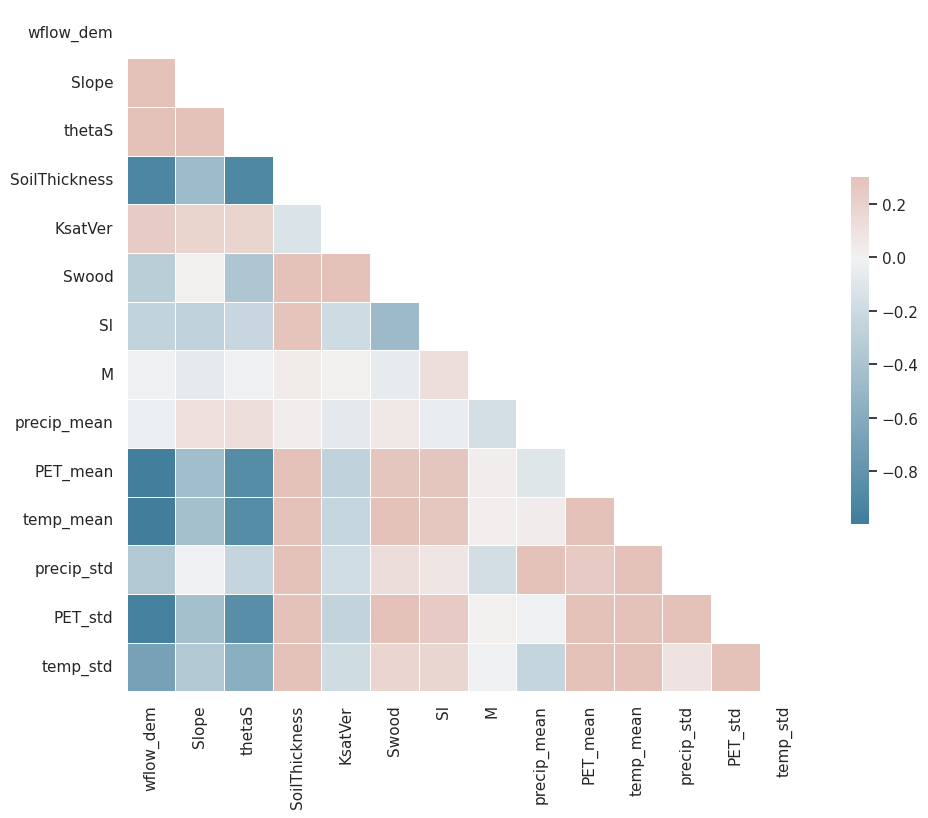

In [2]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

d = pd.DataFrame({
    var: merged_ds[var].values.flatten()
    for var in merged_ds.data_vars
})

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [7]:
merged_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/14)
    wflow_dem      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Slope          (latitude, longitude) float32 161kB nan nan nan ... nan nan
    thetaS         (latitude, longitude) float32 161kB nan nan nan ... nan nan
    SoilThickness  (latitude, longitude) float32 161kB nan nan nan ... nan nan
    KsatVer        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Swood          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    ...             ...
    precip_mean    (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_mean       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float32 161kB nan nan nan ... nan nan

In [8]:
clustered_das

<xarray.DataArray (latitude: 180, longitude: 223)> Size: 321kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude     (latitude) float64 1kB 47.08 47.07 47.06 ... 45.46 45.45 45.44
  * longitude    (longitude) float64 2kB 10.29 10.3 10.31 ... 12.31 12.32 12.33
    spatial_ref  int64 8B ...

In [3]:
merged_ds['clusters'] = clustered_das

In [4]:
merged_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/15)
    wflow_dem      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Slope          (latitude, longitude) float32 161kB nan nan nan ... nan nan
    thetaS         (latitude, longitude) float32 161kB nan nan nan ... nan nan
    SoilThickness  (latitude, longitude) float32 161kB nan nan nan ... nan nan
    KsatVer        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    Swood          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    ...             ...
    PET_mean       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float32 161kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float32 161kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float32 161kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float32 161kB nan nan nan ... nan nan
    clusters       (latitude, longitude) float64 321kB nan nan nan ... nan nan

In [5]:
# Step 2: Min-Max scale each data variable in the dataset
def min_max_scale(da):
    """Scale a DataArray using Min-Max scaling to the range 0-1."""
    return (da - da.min()) / (da.max() - da.min())

# Apply min-max scaling to each variable
scaled_ds = merged_ds.apply(min_max_scale)

print("\nScaled Dataset:")
scaled_ds


Scaled Dataset:


<xarray.Dataset> Size: 5MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/15)
    wflow_dem      (latitude, longitude) float64 321kB nan nan nan ... nan nan
    Slope          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    thetaS         (latitude, longitude) float64 321kB nan nan nan ... nan nan
    SoilThickness  (latitude, longitude) float64 321kB nan nan nan ... nan nan
    KsatVer        (latitude, longitude) float64 321kB nan nan nan ... nan nan
    Swood          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    ...             ...
    PET_mean       (latitude, longitude) float64 321kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float64 321kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float64 321kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float64 321kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float64 321kB nan nan nan ... nan nan
    clusters       (latitude, longitude) float64 321kB nan nan nan ... nan nan

In [6]:
scaled_ds['clusters'] = clustered_das

In [15]:
scaled_ds

<xarray.Dataset> Size: 5MB
Dimensions:        (latitude: 180, longitude: 223)
Coordinates:
  * latitude       (latitude) float64 1kB 47.08 47.07 47.06 ... 45.45 45.44
  * longitude      (longitude) float64 2kB 10.29 10.3 10.31 ... 12.32 12.33
    spatial_ref    int64 8B 0
Data variables: (12/15)
    wflow_dem      (latitude, longitude) float64 321kB nan nan nan ... nan nan
    Slope          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    thetaS         (latitude, longitude) float64 321kB nan nan nan ... nan nan
    SoilThickness  (latitude, longitude) float64 321kB nan nan nan ... nan nan
    KsatVer        (latitude, longitude) float64 321kB nan nan nan ... nan nan
    Swood          (latitude, longitude) float64 321kB nan nan nan ... nan nan
    ...             ...
    PET_mean       (latitude, longitude) float64 321kB nan nan nan ... nan nan
    temp_mean      (latitude, longitude) float64 321kB nan nan nan ... nan nan
    precip_std     (latitude, longitude) float64 321kB nan nan nan ... nan nan
    PET_std        (latitude, longitude) float64 321kB nan nan nan ... nan nan
    temp_std       (latitude, longitude) float64 321kB nan nan nan ... nan nan
    clusters       (latitude, longitude) float64 321kB nan nan nan ... nan nan

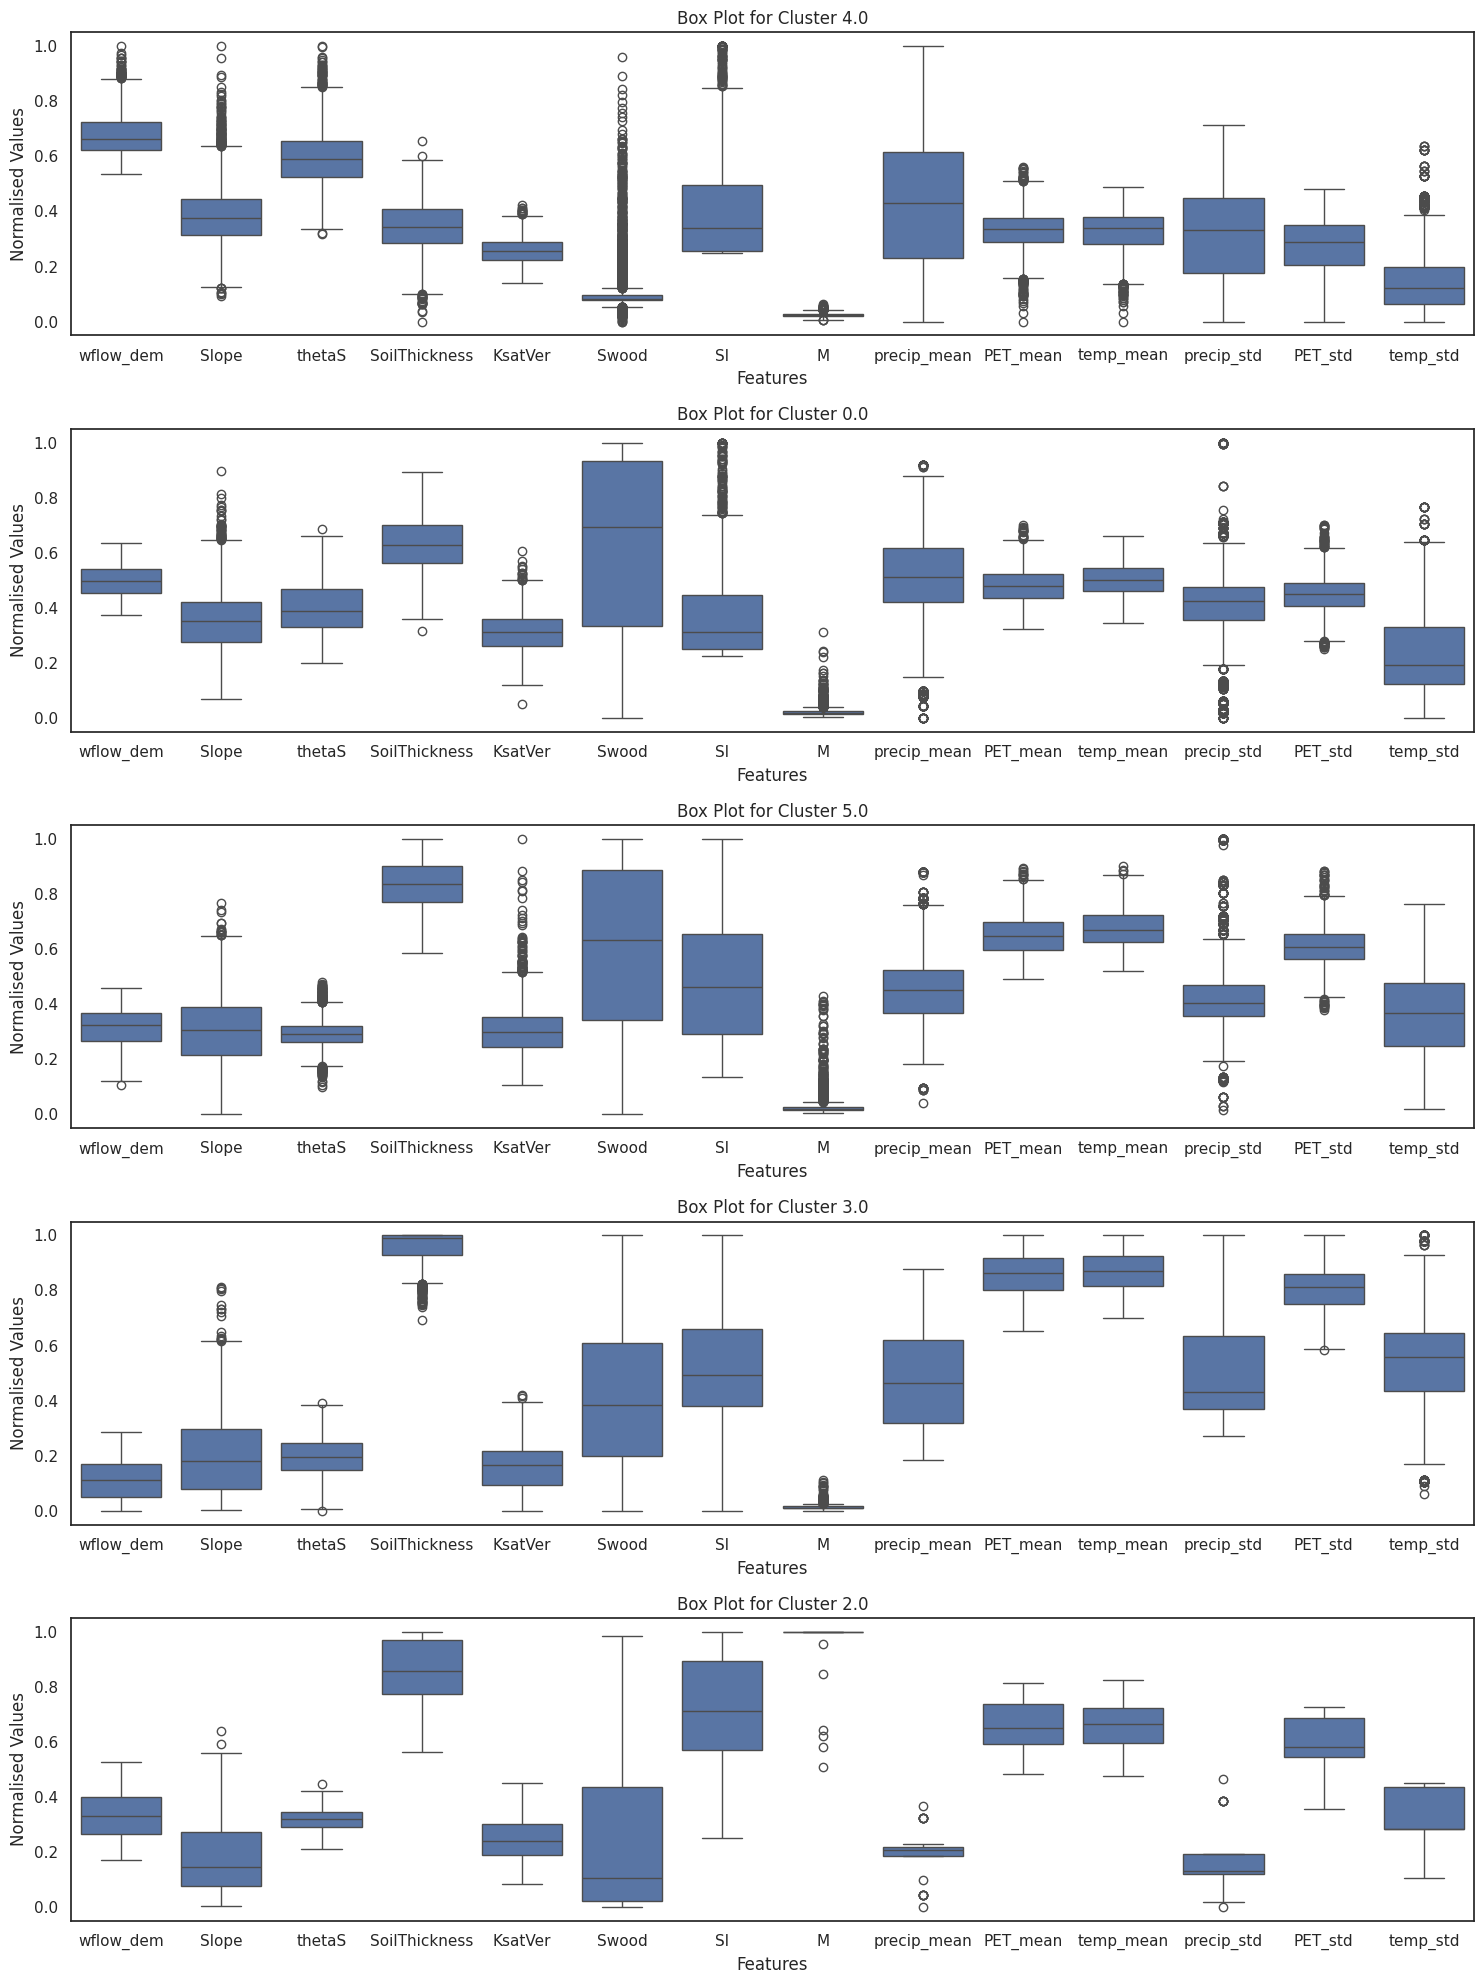

In [11]:
# Step 2: Convert the xarray Dataset to a Pandas DataFrame
df = scaled_ds.to_dataframe().reset_index()

# Step 3: Melt the DataFrame, excluding 'cluster' and coordinate columns
feature_columns = [col for col in df.columns if col not in ['clusters', 'latitude', 'longitude', 'spatial_ref']]
df_melted = df.melt(id_vars='clusters', value_vars=feature_columns, var_name='feature', value_name='value')

# Step 4: Create separate box plots for each cluster
clusters = df['clusters'].dropna().unique()
n_clusters = len(clusters)
plt.figure(figsize=(15, 4 * n_clusters))

for i, cluster in enumerate(clusters, 1):
    plt.subplot(n_clusters, 1, i)
    sns.boxplot(x='feature', y='value', data=df_melted[df_melted['clusters'] == cluster])
    plt.title(f'Box Plot for Cluster {cluster}')
    plt.xlabel('Features')
    plt.ylabel('Normalised Values')

plt.tight_layout()
plt.show()